# vclsi-04 exercise 2

In [1]:
%matplotlib inline


PyTorch Transfer Learning Tutorial
==============================================
**Original Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`

**Modifications**: `Simon Mueller <simue@uni-bonn.de>`

Link to original tutorial: [Link](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)


In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning and a toy dataset.
Additional References:
* [PyTorch Documentation](https://pytorch.org/tutorials)
* [Deep transfer learning tutorial](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)

In practice, very few people train an entire Convolutional Network
from scratch (with random initialization), because it is relatively
rare to have a dataset of sufficient size. Instead, it is common to
pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
contains 1.2 million images with 1000 categories), and then use the
ConvNet either as an initialization or a fixed feature extractor for
the task of interest.

There are two major transfer learning scenarios finetuning and feature extraction.

**Finetuning a convnet**: Instead of random weight and bias generation, we
initialize the model with a pretrained network, for example one optimized for 
the imagenet 1000 challenge dataset. The rest of the finetuning process showcases
how a convoulaitonal network can be trained.

**Features extraction**: Here, we will freeze the weights of a certain amount of layers and only train the remaining ones.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm_notebook as tqdm

plt.ion()   # interactive mode

Exercise 1 (9 Points)
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify two distinct car models form the **stanford cars dataset**. We have about 80 training images each for GMC and Chrysler car models.
There is also a small validation set with images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

We modified the dataset from this address: [Cars 196](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)

1. In the data/-directory are two folders corresponding to the two car models (chrysler and gmc). Split all available images into a training (85%) and validation (15%) set. This can be done manually or with a sklearn method (2P). 
2. Then use the **torchvision.dataset** package to load the images into a training and validation dataset structure. The dataset is also responsible for data transformations. Use the **torchvision.transforms** package to create data augmentations (Flipping, Random Cropping, Rotation) for the training set and the default transformations for the validation set. (Hint: You do not have to create a custom dataset class, look at the ImageFolder class in the PyTorch documentation) (2P).
3. Create datalaoders for both sets. The training set should be shuffled for an effective training procedure (2P).
4. Test one of your data loaders. Load the first batch, undo the transformation of the pytorch tensor and display the images (3P).

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_dir = 'cars2_dataset'
data_transforms = {
    'train': transforms.Compose([
         # resize the input image to the given size.
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomRotation(degrees=(-30,+30)),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
    ]),
}

# Create dataset from folder
dataset_train = datasets.ImageFolder(data_dir,transform = data_transforms['train'])
dataset_val = datasets.ImageFolder(data_dir,transform = data_transforms['val'])

num_train = len(dataset_train) # get number                               
indices = list(range(num_train))                         

split = int(0.15 * num_train) # take 15% as validation
np.random.shuffle(indices)  # shuffle indices of training set

train_idx, val_idx = indices[split:], indices[:split]# get train sample and val sample

from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)            
val_sampler  = SubsetRandomSampler(val_idx)


# Create to data loader for parallel batch loading
loader_train = torch.utils.data.DataLoader(dataset_train,sampler = train_sampler, batch_size = 20)
loader_val = torch.utils.data.DataLoader(dataset_val,sampler = val_sampler, batch_size = 20)
class_names = dataset_train.classes

# Select device for training, default CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'INFO> Using device {device}\n Dataset training size: {len(train_idx)}\n Dataset validation size: {len(val_idx)}')

INFO> Using device cpu
 Dataset training size: 199
 Dataset validation size: 34


In [4]:
# Room for helper methods
#
#
#
# ...

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))   #cast data loader to iterator and get the first element

# Make a grid from a single batch, Hint: torchvision.utils.make_grid
from torchvision.utils import make_grid
makegrid = make_grid(inputs, padding = 30)

# Display the images
def show(image):
    img = image.numpy()
    fig = plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(img,(1,2,0))) 
show(makegrid)   

Exercise 2 (18 Points)
------------------

Now, let's write two general functions to train and validate a model. PyTorch simplifies forward- and backward-propagation, learning rate scheduling and the calculation of the loss. In this you exercise you will implement the necessary steps for our transfer learning dataset.
To better understand the PyTorch library look into the documentation for the ``torch.optim.lr_scheduler``, ``torch.nn.CrossEntropyLoss``, ``torch.optim.SGD``.

1. Complete the function skeletion for the training process. The *model* will be adapted by the *optimizer* according to the loss function (*criterion*) for *num_epochs* (7P).
2. Write the function for the validation process. The *model* should not be optimized and the whole dataset is only processed once (5P).
3. Now load a pretrained Resnet2018, delete the last fully connected layer and replace it with a custom one that only has two output values: ``torch.nn.Linear``. Next create an instance of the CrossEntropyLoss. For the optimizer either an *Stochastic Gradient Descent* or *Adam* can be used. Call the ``train_model`` function with the initialized instances and train the *model* for 15 epochs (6P).

Hint: The training should take around 15-25 min on a CPU. On a GPU though, it takes less than a minute.


In [6]:

import torch.nn.functional as F

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_accuracy = 0.0
    # Track accuracy and loss for the validation and training data
    stats = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in tqdm(enumerate(loader_train), total=len(loader_train), desc=f'Epoch {epoch}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward propagation
            result = model.forward(inputs) #result 
        
            loss = criterion(result, labels)
            
            # backward propagation + optimization
            loss.backward()
            optimizer.step()
            
            # save epoch statistics, loss and accuracy
            running_loss += loss.item()*inputs.size(0)
            #probs = F.softmax(result, dim = 1)
            max_probs, preds = torch.max(result,dim = 1)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()
        
        # Accumulate statistics for the epoch
        epoch_loss = running_loss/len(dataset_train)
        epoch_acc = running_corrects.double()/len(dataset_train)
        
        print(f'Epoch {epoch}:')
        print(f'Training loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        # get validation metrics and save the best model 
        val_acc, val_loss = validate_model(model, criterion, epoch)
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(),'best_model.pth')
        
        stats['train'].append((epoch_loss, epoch_acc))
        stats['val'].append((val_loss, val_acc))


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Accuracy: {best_accuracy:4f}')

    # load best model weights
    model.load_state_dict(torch.load('best_model.pth'))
    return model, stats




In [7]:
import torch.nn.functional as F
import torchmetrics

def validate_model(model, criterion, cur_epoch):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for i, (inputs, labels) in tqdm(enumerate(loader_val), total=len(loader_val), desc='Validation'):
        
        # Move data and labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Do not track gradients for validation phase
        with torch.no_grad():
            # Forward propagation
            result = model.forward(inputs)
        
        # Calculate statistics
            loss_ = criterion(result, labels)
            running_loss += loss_.item()*inputs.size(0)
            #probs = F.softmax(result, dim = 1)
            max_probs, preds = torch.max(result,dim = 1)
            running_corrects += torch.sum(preds == labels.data)
    
    # Calculate dataset statistics
    loss = running_loss/len(dataset_val)
    accuracy = running_corrects.double()/len(dataset_val)
    
    print(f' Validation loss: {loss:.4f}, Accuracy: {accuracy:.4f}')
    
    return accuracy, loss


reference:https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation

In [8]:
# First load a pretrained (ImageNet challenge) resnet18 model 
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features

# We want to make a binary prediction so the last layer has to be recreated accordingly
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

# Create an instance of the loss function
criterion = nn.CrossEntropyLoss()

# Create an optimizer, Hint: default parameters SGD lr=0.001, momentum=0.9, Adam: lr=0.0001
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum = 0.9)

# Example for the LR decay by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
num_epochs = 15
model, stats = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

<ipython-input-6-790a3e641622>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (inputs, labels) in tqdm(enumerate(loader_train), total=len(loader_train), desc=f'Epoch {epoch}'):



Epoch 0:
Training loss: 0.5340, Accuracy: 0.5579


<ipython-input-7-2017560091cf>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (inputs, labels) in tqdm(enumerate(loader_val), total=len(loader_val), desc='Validation'):



 Validation loss: 0.0597, Accuracy: 0.1373



Epoch 1:
Training loss: 0.3942, Accuracy: 0.6996



 Validation loss: 0.0283, Accuracy: 0.1459



Epoch 2:
Training loss: 0.2819, Accuracy: 0.7597



 Validation loss: 0.0192, Accuracy: 0.1459



Epoch 3:
Training loss: 0.1949, Accuracy: 0.7940



 Validation loss: 0.0064, Accuracy: 0.1459



Epoch 4:
Training loss: 0.1533, Accuracy: 0.8069



 Validation loss: 0.0068, Accuracy: 0.1459



Epoch 5:
Training loss: 0.1698, Accuracy: 0.7897



 Validation loss: 0.0052, Accuracy: 0.1459



Epoch 6:
Training loss: 0.1138, Accuracy: 0.8112



 Validation loss: 0.0019, Accuracy: 0.1459



Epoch 7:
Training loss: 0.0895, Accuracy: 0.8283



 Validation loss: 0.0021, Accuracy: 0.1459



Epoch 8:
Training loss: 0.1105, Accuracy: 0.8240



 Validation loss: 0.0024, Accuracy: 0.1459



Epoch 9:
Training loss: 0.1355, Accuracy: 0.8026



 Validation loss: 0.0022, Accuracy: 0.1459



Epoch 10:
Training loss: 0.1291, Accuracy: 0.8026



 Validation loss: 0.0029, Accuracy: 0.1459



Epoch 11:
Training loss: 0.0892, Accuracy: 0.8240



 Validation loss: 0.0031, Accuracy: 0.1459



Epoch 12:
Training loss: 0.0834, Accuracy: 0.8412



 Validation loss: 0.0032, Accuracy: 0.1459



Epoch 13:
Training loss: 0.1037, Accuracy: 0.8283



 Validation loss: 0.0023, Accuracy: 0.1459



Epoch 14:
Training loss: 0.1095, Accuracy: 0.8155



 Validation loss: 0.0029, Accuracy: 0.1459
Training complete in 11m 52s
Best val Accuracy: 0.145923


we can see overfitting occurs here. the validation accuracy did not increase.

Exercise 3 (5 Points)
------
Now that we have successfully fine-tuned a network, a closer look at the final model and the learning process is in order:

1. Create a function that predicts a class for the provided pictures. You can use the trained model from the last exercise. 4 test images are located in the root folder of this sheet (2P).
2. Use the ``matplotlib`` package to plot learning curves for the training and validation set. You can use the statistic values accumulated in the **stats** variable (3P).

![image.png](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FLearning-curve-assessing-the-PACE-GF-random-forest-machine-learning-algorithm-for-n_fig2_335070569&psig=AOvVaw20b5GcgCMlANpOR7797f88&ust=1592473813216000&source=images&cd=vfe&ved=0CAIQjRxqGAoTCOia5bTJiOoCFQAAAAAdAAAAABDoAQQ)

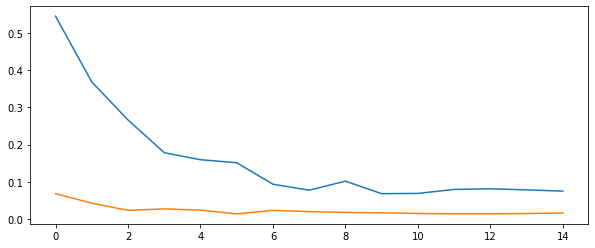

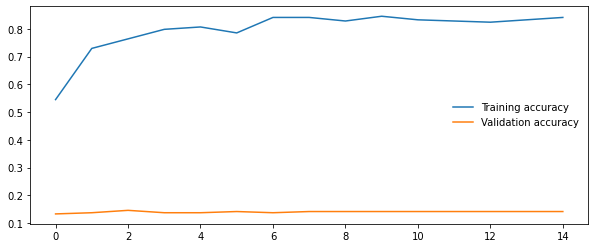

In [31]:

def draw_curve(stats):
    ''' show the curve of loss function.'''
    train_loss = [i for i ,j in stats['train']]
    val_loss = [i for i,j in stats['val']]
    
    train_acc = [j for i ,j in stats['train']]
    val_acc = [j for i,j in stats['val']]
    
    fig1 = plt.figure('Loss function', figsize = (10,4)).add_subplot(111)
    fig1.plot(train_loss, label='Training loss')
    fig1.plot(val_loss, label='Validation loss')
    
    fig2 = plt.figure('accuracy', figsize = (10,4)).add_subplot(111)
    fig2.plot(train_acc, label='Training accuracy')
    fig2.plot(val_acc, label='Validation accuracy')
    plt.legend(frameon=False)
    plt.show()
draw_curve(stats)

def predict_sample(model, sample):
    pass

In [ ]:
plt.ioff()
plt.show()